# 02 — Chunking & Embedding

Take parsed provisions from Notebook 01, chunk them into embedding-ready pieces, embed with OpenAI `text-embedding-3-small`, and build a ChromaDB vector index.

**Prerequisites**: Run Notebook 01 first (or have `data/chunks/provisions.json`).

In [4]:
import sys
sys.path.insert(0, "..")

from src.parsing import load_provisions
from src.chunking import chunk_provisions, count_tokens
from src.embeddings import build_index, search, get_openai_client

LANG = "de"  # change to "en" for English

## Load & chunk provisions

In [5]:
provisions = load_provisions(f"../data/chunks/provisions_{LANG}.json")
chunks = chunk_provisions(provisions)
print(f"Language: {LANG}")
print(f"Total chunks: {len(chunks)}")

from collections import Counter
type_counts = Counter(c['metadata']['type'] for c in chunks)
for t, count in type_counts.items():
    print(f"  {t}: {count}")

Language: de
Total chunks: 361
  article: 154
  recital: 184
  annex: 23


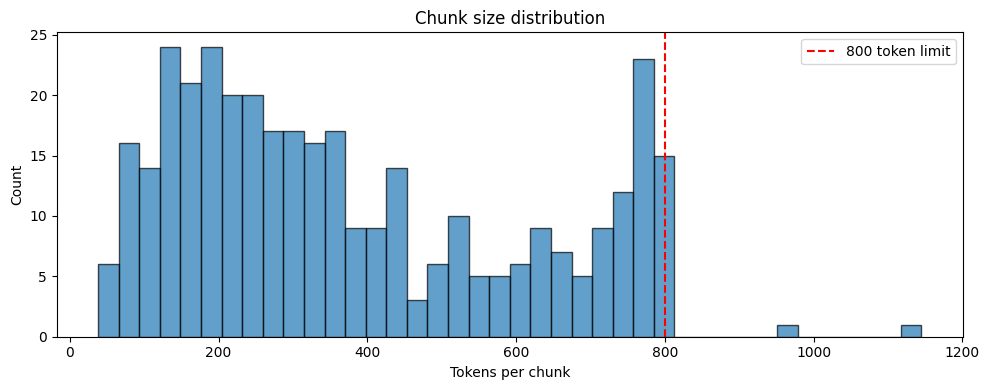

Min: 38, Max: 1145, Avg: 382
Over 800 tokens: 2


In [6]:
# Token distribution
import matplotlib.pyplot as plt

token_counts = [count_tokens(c['text']) for c in chunks]

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(token_counts, bins=40, edgecolor='black', alpha=0.7)
ax.set_xlabel('Tokens per chunk')
ax.set_ylabel('Count')
ax.set_title('Chunk size distribution')
ax.axvline(x=800, color='red', linestyle='--', label='800 token limit')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Min: {min(token_counts)}, Max: {max(token_counts)}, Avg: {sum(token_counts)/len(token_counts):.0f}")
print(f"Over 800 tokens: {sum(1 for t in token_counts if t > 800)}")

## Build ChromaDB index

In [7]:
client = get_openai_client()
collection = build_index(chunks, chroma_path="../chroma_db", client=client, lang=LANG)
print(f"\nIndex built: {collection.count()} chunks indexed")

  Indexed 100/361 chunks
  Indexed 200/361 chunks
  Indexed 300/361 chunks
  Indexed 361/361 chunks

Index built: 361 chunks indexed


## Test retrieval

In [8]:
from src.embeddings import get_collection
collection = get_collection("../chroma_db", lang=LANG)

# Test: Welche KI-Praktiken sind verboten?
query = "Welche KI-Praktiken sind verboten?" if LANG == "de" else "What AI practices are prohibited?"
results = search(query, collection=collection, client=client)
print(f"Query: '{query}'\n")
for r in results[:5]:
    print(f"  [{r['metadata']['type']}] {r['metadata']['title'][:60]}  (dist: {r['distance']:.3f})")

Query: 'Welche KI-Praktiken sind verboten?'

  [recital] Erwägungsgrund 29  (dist: 0.305)
  [article] Artikel 5 — Verbotene Praktiken im KI-Bereich  (dist: 0.349)
  [article] Artikel 5 — Verbotene Praktiken im KI-Bereich  (dist: 0.352)
  [recital] Erwägungsgrund 26  (dist: 0.359)
  [recital] Erwägungsgrund 56  (dist: 0.370)


In [9]:
# Test: Anforderungen an Hochrisiko-KI-Systeme
query = "Anforderungen an Hochrisiko-KI-Systeme" if LANG == "de" else "requirements for high-risk AI systems"
results = search(query, collection=collection, client=client)
print(f"Query: '{query}'\n")
for r in results[:5]:
    print(f"  [{r['metadata']['type']}] {r['metadata']['title'][:60]}  (dist: {r['distance']:.3f})")

Query: 'Anforderungen an Hochrisiko-KI-Systeme'

  [recital] Erwägungsgrund 75  (dist: 0.266)
  [recital] Erwägungsgrund 52  (dist: 0.275)
  [recital] Erwägungsgrund 26  (dist: 0.279)
  [recital] Erwägungsgrund 85  (dist: 0.280)
  [article] Artikel 15 — Genauigkeit, Robustheit und Cybersicherheit  (dist: 0.284)


In [10]:
# Test: Metadata filtering — nur Artikel aus Kapitel III
query = "Daten-Governance" if LANG == "de" else "data governance"
results = search(
    query,
    where={"chapter": "III"},
    collection=collection,
    client=client,
)
print(f"Query: '{query}' (Kapitel III)\n")
for r in results[:5]:
    print(f"  {r['metadata']['title'][:60]}  (dist: {r['distance']:.3f})")

Query: 'Daten-Governance' (Kapitel III)

  Artikel 10 — Daten und Daten-Governance  (dist: 0.394)
  Artikel 10 — Daten und Daten-Governance  (dist: 0.449)
  Artikel 26 — Pflichten der Betreiber von Hochrisiko-KI-Syste  (dist: 0.527)
  Artikel 26 — Pflichten der Betreiber von Hochrisiko-KI-Syste  (dist: 0.544)
  Artikel 26 — Pflichten der Betreiber von Hochrisiko-KI-Syste  (dist: 0.553)
